In [1]:
#We get all dependencis we need for a Random Forest
#If you need a module do: "!pip install [module_name]""
import numpy as np
import pandas as pd
import secrets
import matplotlib.pylab as plt
import itertools
import pydot
import pickle
import sys

from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from collections import Counter
from subprocess import call
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz

In [2]:
# Get the URL of the video we want to create highlights on
url = "https://www.youtube.com/watch?v=xqtZf2dIZzQ"
vidId = url.replace('https://www.youtube.com/watch?v=', '')

In [3]:
# Get the data extracted from our video
db_conn_str = "mysql+pymysql://{:}:{:}@{:}/{:}".format(secrets.user, secrets.password, secrets.host, secrets.db)
db_conn = create_engine(db_conn_str)
df = pd.read_sql('SELECT * FROM clips WHERE url ="'+ url +'"', con=db_conn)

print('Number of Rows:', len(df.index))
db_conn.dispose()

Number of Rows: 1603


In [4]:
features_df = df[['pitch', 'amplitude', 'subjectivity', 'polarity', 'pred_excitement']]

In [5]:
# Separate our tags and features
X = features_df
X.head()

,pitch,amplitude,subjectivity,polarity,pred_excitement
0,58.9881,-0.000314,0.000000,0.000000,1
1,62.4685,0.000153,0.000000,0.000000,0
2,61.2615,-0.000189,0.068182,0.072727,0
3,63.7713,-0.000578,0.033333,0.033333,0
4,66.3894,0.000076,0.050376,0.031579,0


In [6]:
# Get model predictions
rf_predictions = df['pred_highlight_rf']
nn_predictions = df['pred_highlight_nn']

In [7]:
# get youtube embeded url
def formatYoutubeUrl(url, start, end):
  embed_url = url.replace("watch?v=", "embed/")
  params = "?start={:}&end={:}&autoplay=1".format(start, end)
  return embed_url + params

def printUrls(df):
    for idx, row in df.iterrows():
        print(formatYoutubeUrl(row['url'], row['start'], row['end']))

In [8]:
# all non-highlight clips
non_highlight_rf = df[df['pred_highlight_rf'] == 0]
non_highlight_nn = df[df['pred_highlight_nn'] == 0]

# all non-highlight clips
highlight_rf = df[df['pred_highlight_rf'] == 1]
highlight_nn = df[df['pred_highlight_nn'] == 1]

# print URLs
print('=== NON-HIGHLIGHT RF ===')
printUrls(non_highlight_rf.sample(20))

print('=== HIGHLIGHT RF ===')
printUrls(highlight_rf.sample(20))

print('=== NON-HIGHLIGHT NN ===')
printUrls(non_highlight_nn.sample(20))

print('=== HIGHLIGHT NN ===')
printUrls(highlight_nn.sample(20))

=== NON-HIGHLIGHT RF ===
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2356&end=2360&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2392&end=2396&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2030&end=2034&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1084&end=1088&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=844&end=848&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1468&end=1472&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3164&end=3168&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3032&end=3036&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2404&end=2408&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2274&end=2278&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=52&end=56&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1788&end=1792&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2136&end=2140&autoplay=1
https://www.youtube.com/embed/xq

In [9]:
# Output Predictions vs Actual results
for idx, row in df.iterrows():
    print(formatYoutubeUrl(row['url'], row['start'], row['end']), "Predicted RF: " ,row['pred_highlight_rf'], "Predicted NN: " ,row['pred_highlight_nn'])

https://www.youtube.com/embed/xqtZf2dIZzQ?start=0&end=4&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2&end=6&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=4&end=8&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=6&end=10&autoplay=1 Predicted RF:  1 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=8&end=12&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=10&end=14&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=12&end=16&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=14&end=18&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=16&end=20&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=18&end=22&autoplay=1 Predicted RF

https://www.youtube.com/embed/xqtZf2dIZzQ?start=182&end=186&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=184&end=188&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=186&end=190&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=188&end=192&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=190&end=194&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=192&end=196&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=194&end=198&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=196&end=200&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=198&end=202&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=200&end

https://www.youtube.com/embed/xqtZf2dIZzQ?start=394&end=398&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=396&end=400&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=398&end=402&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=400&end=404&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=402&end=406&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=404&end=408&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=406&end=410&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=408&end=412&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=410&end=414&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=412&end

https://www.youtube.com/embed/xqtZf2dIZzQ?start=736&end=740&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=738&end=742&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=740&end=744&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=742&end=746&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=744&end=748&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=746&end=750&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=748&end=752&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=750&end=754&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=752&end=756&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=754&end

https://www.youtube.com/embed/xqtZf2dIZzQ?start=964&end=968&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=966&end=970&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=968&end=972&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=970&end=974&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=972&end=976&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=974&end=978&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=976&end=980&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=978&end=982&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=980&end=984&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=982&end

https://www.youtube.com/embed/xqtZf2dIZzQ?start=1234&end=1238&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1236&end=1240&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1238&end=1242&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1240&end=1244&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1242&end=1246&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1244&end=1248&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1246&end=1250&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1248&end=1252&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1250&end=1254&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=1528&end=1532&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1530&end=1534&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1532&end=1536&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1534&end=1538&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1536&end=1540&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1538&end=1542&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1540&end=1544&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1542&end=1546&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1544&end=1548&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=1706&end=1710&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1708&end=1712&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1710&end=1714&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1712&end=1716&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1714&end=1718&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1716&end=1720&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1718&end=1722&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1720&end=1724&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1722&end=1726&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=2136&end=2140&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2138&end=2142&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2140&end=2144&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2142&end=2146&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2144&end=2148&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2146&end=2150&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2148&end=2152&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2150&end=2154&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2152&end=2156&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=2288&end=2292&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2290&end=2294&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2292&end=2296&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2294&end=2298&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2296&end=2300&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2298&end=2302&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2300&end=2304&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2302&end=2306&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2304&end=2308&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=2506&end=2510&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2508&end=2512&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2510&end=2514&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2512&end=2516&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2514&end=2518&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2516&end=2520&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2518&end=2522&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2520&end=2524&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2522&end=2526&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=2750&end=2754&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2752&end=2756&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2754&end=2758&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2756&end=2760&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2758&end=2762&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2760&end=2764&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2762&end=2766&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2764&end=2768&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2766&end=2770&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=3032&end=3036&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3034&end=3038&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3036&end=3040&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3038&end=3042&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3040&end=3044&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3042&end=3046&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3044&end=3048&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3046&end=3050&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3048&end=3052&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time

def secondsToTime(secs):
    m, s = divmod(secs, 60)
    return "{:}:{:}".format(m, s)

def realTimeHypeGraph(df):
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plt.ion()

    fig.show()
    fig.canvas.draw()

    x = []
    y1 = []
    y2 = []
    y3 = []
    
    plt.tight_layout()
    plt.subplots_adjust(left = 0.125, wspace = 0.2)
    
    for idx, row in df.iterrows():
        ax1.clear()
        ax1.set_ylim([-0.5, 2.5])
        ax2.clear()
        ax2.set_ylim([-0.5, 2.5])
        
        videoTime = row['start'] / 60
        x.append(videoTime)
        y1.append(row['pred_highlight_rf'])
        y2.append(row['pred_highlight_nn'] + 0.02)
        y3.append(row['pred_excitement'])

        ax1.plot(x[-20:], y1[-20:], label='random_forest', alpha=0.7)
        ax1.plot(x[-20:], y2[-20:], label='neural_network', alpha=0.7)
        ax2.plot(x[-20:], y3[-20:], label='predict_excitement', alpha=0.9, color='red')
        
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Highlight')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Excitement Level')
        
        ax1.legend(loc="upper right")
        ax2.legend(loc="upper right")
        
        fig.canvas.draw()
        time.sleep(2)

In [15]:
from IPython.display import HTML

youtubeEmbedUrl = url.replace('watch?v=', 'embed/')
# Youtube
HTML("<iframe width='560' height='315' src='{:}'</iframe>".format(youtubeEmbedUrl))

<IPython.core.display.Javascript object>


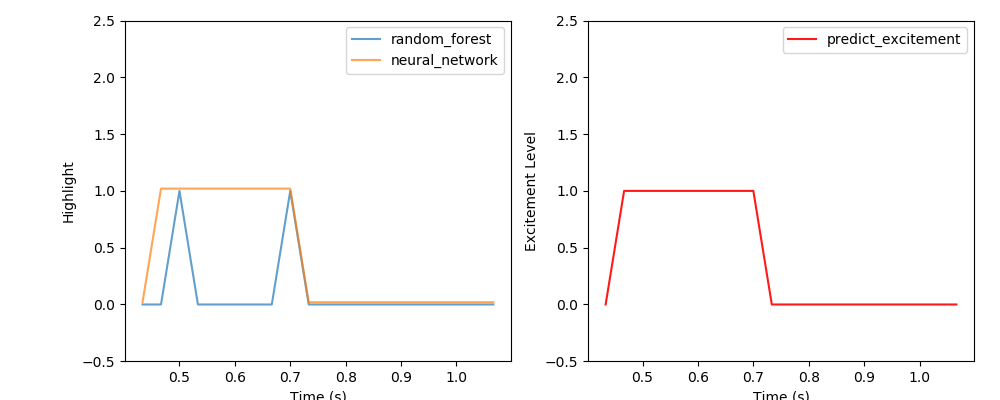

In [ ]:
# run this cell right before you click play on the youtube video
# Also run starting at 2640
dataset = df[df['start'] >= 0] # you can customize the start time here
realTimeHypeGraph(dataset)

In [ ]:
# Display our highlight reel
highlight_url = "https://www.youtube.com/watch?v=y4LABn8RNT0&fbclid=IwAR1v7yEFpuApcZnBE5Ze0fJ3efwTxSN2euBVSXrX8qg9ed_NgKNdi2MDP08"